In [1]:
from __future__ import division

import gym
import numpy as np
import random
import tensorflow as tf
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os
%matplotlib inline

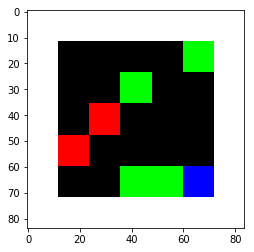

In [2]:
from gridWorld import gridworld

env = gridworld.gameEnv(partial=False, size=5)

In [3]:
class Qnetwork():
	def __init__(self, h_size):
		# 네트워크는 게임으로부터 하나의 프레임을 받아 이를 배열로 만든다.
		# 배열의 크기를 재조절하고 4개의 합성곱 계층을 거쳐 처리하낟.
		self.scalarInput = tf.placeholder(shape=[None, 21168], dtype=tf.float32)
		self.imageIn = tf.reshape(self.scalarInput, shape=[-1,84,84,3])
		self.conv1 = slim.conv2d(inputs=self.imageIn, num_outputs=32, kernel_size=[8,8], stride=[4,4], padding="VALID", biases_initializer=None)
		self.conv2 = slim.conv2d(inputs=self.conv1, num_outputs=64, kernel_size=[4,4], stride=[2,2], padding="VALID", biases_initializer=None)
		self.conv3 = slim.conv2d(inputs=self.conv2, num_outputs=64, kernel_size=[3,3], stride=[1,1], padding="VALID", biases_initializer=None)
		self.conv4 = slim.conv2d(inputs=self.conv3, num_outputs=h_size, kernel_size=[7,7], stride=[1,1], padding="VALID", biases_initializer=None)
		
		# 마지막 합성곱 계층에서 출력값을 취한 후
		# 이를 어드밴티지 스트림과 가치 스트림으로 분리한다.
		
		self.streamAC, self.streamVC = tf.split(self.conv4, 2, 3)
		self.streamA = slim.flatten(self.streamAC)
		self.streamV = slim.flatten(self.streamVC)
		self.AW= tf.Variable(tf.random_normal([h_size//2, env.actions]))
		self.VW = tf.Variable(tf.random_normal([h_size//2, 1]))
		self.Advantage = tf.matmul(self.streamA, self.AW)
		self.Value = tf.matmul(self.streamV, self.VW)
		
		# 최종 Q 값을 얻기 위해 어드밴티지 스트림과 가치 스트림을 조합한다.
		self.Qout = self.Value + tf.subtract(self.Advantage, tf.reduce_mean(self.Advantage, axis=1, keep_dims=True))
		self.predict = tf.argmax(self.Qout, 1)
		
		# 타깃 Q 값과 예측 Q 값의 차의 제곱합을 구하여 비용을 얻는다.
		self.targetQ = tf.placeholder(shape=[None], dtype=tf.float32)
		self.actions = tf.placeholder(shape=[None], dtype=tf.int32)
		self.actions_onehot = tf.one_hot(self.actions, env.actions, dtype=tf.float32)
		
		self.Q = tf.reduce_sum(tf.multiply(self.Qout, self.actions_onehot), axis=1)
		
		self.td_error = tf.square(self.targetQ - self.Q)
		self.loss = tf.reduce_mean(self.td_error)
		self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
		self.updateModel = self.trainer.minimize(self.loss)
		
		
class experience_buffer():
	def __init__(self, buffer_size=50000):
		self.buffer= []
		self.buffer_size = buffer_size
		
	def add(self, experience):
		if len(self.buffer) + len(experience) >= self.buffer_size:
			self.buffer[0:(len(experience) + len(self.buffer)) - self.buffer_size] = []
		self.buffer.extend(experience)
		
	def sample(self, size):
		return np.reshape(np.array(random.sample(self.buffer, size)), [size, 5])
	
def processState(state):
	return np.reshape(state, [21168])

def updateTargetGraph(tfVars, tau):
	total_vars = len(tfVars)
	op_holder = []
	for idx, var in enumerate(tfVars[0:total_vars//2]):
		op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau) + ((1-tau)*tfVars[idx+total_vars//2].value())))
		
	return op_holder

def updateTarget(op_holder, sess):
	for op in op_holder:
		sess.run(op)
		


In [12]:
batch_size = 32  # 각 학습 단계에서 사용할 경험 배치의 수
update_freq = 4  # 학습 단계 업데이트 빈도
y = .99  # 타깃 Q 값에 대한 할인 계수
startE = 1  # 랜덤한 액션을 시작할 가능성
endE = 0.1  # 랜덤한 액션을 끝낼 가능성
anneling_steps = 10000  # startE에서 endE로 줄어드는 데 필요한 학습 단계 수
num_episodes = 10000  # 네트워크를 학습시키시 위한 게임 환경 에피소드의 수
pre_train_steps = 10000  # 학습 시작 전 랜덤 액션의 단계 수
max_epLength = 50  # 허용되는 최대 에피소드 길이
load_model = False  # 저장된 모델을 로드할지 여부
path = "./dqn"  # 모델을 저장할 경로
h_size = 512  # 어드밴티지/가치 스트림으로 분리되기 전 마지막 합성곱 계층의 크기
tau = 0.001  # 타깃 네트워크를 제1 네트워크로 업데이트하는 비율

In [13]:
tf.reset_default_graph()
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)


init = tf.global_variables_initializer()

saver = tf.train.Saver()

trainables = tf.trainable_variables()

targetOps = updateTargetGraph(trainables, tau)

myBuffer = experience_buffer()

# 랜덤 액션이 감소하는 비율을 설정
e = startE
stepDrop = (startE - endE)/anneling_steps

# 보상의 총계와 에피소드별 단계 수를 담을 리스트를 생성한다.
jList = []
rList = []
total_steps = 0

# 모델을 저장할 경로를 생성한다.
if not os.path.exists(path):
	os.makedirs(path)
	
with tf.Session() as sess:
	sess.run(init)
	if load_model is True:
		print("Loading Model...")
		ckpt = tf.train.get_checkpoint_state(path)
		saver.restore(sess, ckpt.model_checkpoint_path)
		
	# 타깃 네트워크가 제1 네트워크와 동일하도록 설정
	updateTarget(targetOps, sess)
	for episode in range(num_episodes):
		episodeBuffer = experience_buffer()
		# 환경을 리셋하고 첫 번째 새로운 관찰을 얻는다.
		s = env.reset()
		s = processState(s)
		done = False
		rAll = 0
		j = 0
		# Q 네트워크
		# 에이전트가 블록에 도달하기까지 최대 50회 시도하고 종료
		while j < max_epLength:
			j += 1
			# Q 네트워크에서 (e의 확률로 랜덤한 액션과 함께) 그리디하게 액션을 선택
			if np.random.rand(1) < e or total_steps < pre_train_steps:
				a = np.random.randint(0, 4)
			else:
				a = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:[s]})[0]
			s1, r, done = env.step(a)
			s1 = processState(s1)
			total_steps += 1
			# 에피소드 버퍼에 경험을 저장
			episodeBuffer.add(np.reshape(np.array([s, a, r, s1, done]), [1,5]))
			
			if total_steps > pre_train_steps:
				if e > endE:
					e -= stepDrop
				if total_steps % (update_freq) == 0:
					# 경험에서 랜덤하게 배치 하나를 샘플링
					trainBatch = myBuffer.sample(batch_size)
					
					# 타깃 Q 값에 대해 더블 DQN 업데이트를 수행
					Q1 = sess.run(mainQN.predict, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
					Q2 = sess.run(targetQN.Qout, feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
					end_multiplier = -(trainBatch[:,4] - 1)
					doubleQ = Q2[range(batch_size), Q1]
					targetQ = trainBatch[:,2] + (y * doubleQ * end_multiplier)
					# 타깃 값을 이용해 네트워크를 업데이트
					_ = sess.run(mainQN.updateModel, feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,0]), mainQN.targetQ:targetQ, mainQN.actions:trainBatch[:,1]})
					
					# 타깃 네트워크가 제1 네트워크와 동일하도록 설정
					updateTarget(targetOps, sess)
			
			rAll += r
			s = s1
			
			if done:
				break
				
		myBuffer.add(episodeBuffer.buffer)
		jList.append(j)
		rList.append(rAll)
		# 정기적으로 모델 저장
		
		if episode % 1000 == 0:
			saver.save(sess, path+"/model-" + str(episode) + ".cptk")
			print("Saved Model")
		if len(rList) % 10 == 0:
			print(total_steps, np.mean(rList[-10:]), e)
					
	saver.save(sess, path + "/model-" + str(episode) + ".cptk")

print("Precent of Successful episodes: " + str(sum(rList)/num_episodes))


Saved Model
500 1.8 1


1000 2.2 1
1500 1.7 1


2000 1.7 1
2500 1.4 1


3000 2.2 1
3500 2.6 1


4000 1.9 1
4500 1.1 1


5000 2.2 1
5500 1.2 1


6000 3.3 1
6500 1.9 1


7000 1.9 1
7500 2.6 1


8000 1.5 1
8500 2.6 1


9000 2.1 1
9500 2.2 1


10000 2.2 1


10500 2.4 0.9549999999999828


11000 2.2 0.9099999999999655


11500 0.8 0.8649999999999483


12000 1.9 0.819999999999931


12500 0.6 0.7749999999999138


13000 2.0 0.7299999999998965


13500 2.5 0.6849999999998793


14000 2.3 0.639999999999862


14500 1.2 0.5949999999998448


15000 1.9 0.5499999999998275


15500 2.4 0.5049999999998103


16000 1.3 0.4599999999998177


16500 0.9 0.41499999999982823


17000 0.6 0.36999999999983874


17500 2.3 0.32499999999984924


18000 1.3 0.27999999999985975


18500 0.2 0.23499999999986562


19000 1.8 0.18999999999986225


19500 1.2 0.14499999999985888


20000 0.5 0.09999999999985551


20500 1.3 0.09999999999985551


21000 1.3 0.09999999999985551


21500 0.4 0.09999999999985551


22000 1.7 0.09999999999985551


22500 1.3 0.09999999999985551


23000 1.1 0.09999999999985551


23500 0.8 0.09999999999985551


24000 0.8 0.09999999999985551


24500 0.5 0.09999999999985551


25000 0.9 0.09999999999985551


25500 1.1 0.09999999999985551


26000 0.6 0.09999999999985551


26500 1.0 0.09999999999985551


27000 1.0 0.09999999999985551


27500 0.2 0.09999999999985551


28000 0.6 0.09999999999985551


28500 1.1 0.09999999999985551


29000 0.9 0.09999999999985551


29500 1.4 0.09999999999985551


30000 0.9 0.09999999999985551


30500 0.9 0.09999999999985551


31000 0.8 0.09999999999985551


31500 0.6 0.09999999999985551


32000 0.9 0.09999999999985551


32500 0.6 0.09999999999985551


33000 0.7 0.09999999999985551


33500 0.6 0.09999999999985551


34000 2.5 0.09999999999985551


34500 0.8 0.09999999999985551


35000 0.9 0.09999999999985551


35500 1.1 0.09999999999985551


36000 1.4 0.09999999999985551


36500 0.9 0.09999999999985551


37000 1.3 0.09999999999985551


37500 1.1 0.09999999999985551


38000 1.4 0.09999999999985551


38500 1.7 0.09999999999985551


39000 0.9 0.09999999999985551


39500 0.6 0.09999999999985551


40000 1.2 0.09999999999985551


40500 1.8 0.09999999999985551


KeyboardInterrupt: 

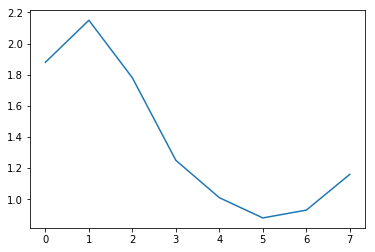

In [14]:
rMat = np.resize(np.array(rList), [len(rList)//100,100])

rMean = np.average(rMat, 1)
plt.plot(rMean)

InvalidArgumentError: Cannot assign a device for operation 'MatMul_5': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul_5 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a_1, b_1)]]

Caused by op 'MatMul_5', defined at:
  File "C:\Python\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Python\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Python\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Python\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Python\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-9278c3aa0825>", line 5, in <module>
    c = tf.matmul(a, b)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2064, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2790, in _mat_mul
    name=name)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'MatMul_5': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul_5 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a_1, b_1)]]


InvalidArgumentError: Cannot assign a device for operation 'MatMul_5': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul_5 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a_1, b_1)]]

Caused by op 'MatMul_5', defined at:
  File "C:\Python\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Python\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tornado\platform\asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "C:\Python\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Python\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Python\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tornado\platform\asyncio.py", line 122, in _handle_events
    handler_func(fileobj, events)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tornado\stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2705, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2809, in run_ast_nodes
    if self.run_code(code, result):
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\IPython\core\interactiveshell.py", line 2869, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-9278c3aa0825>", line 5, in <module>
    c = tf.matmul(a, b)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\ops\math_ops.py", line 2064, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 2790, in _mat_mul
    name=name)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "G:\workspace\ML\threeMin\venv\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'MatMul_5': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul_5 = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a_1, b_1)]]
